In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import genesis as gs
# show the iamge
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


[I 04/18/25 17:13:18.998 69085] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [3]:
import random
import pathlib as pl
import numpy as np
import os, sys
import torch

USE_EEF = False
FINGERTIP_POS = -0.9
KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]


In [4]:
gs.init(backend=gs.gpu, seed=random.randint(0, 2**30), precision="32", logging_level="warning")

In [5]:
scene = gs.Scene(
            show_viewer=True,
        )

# path to current notebook
nb_path = os.path.abspath('nb.ipynb')
nb_path = pl.Path(nb_path)

kinova = scene.add_entity(
            gs.morphs.URDF(
                file=str(nb_path.parent / 'gen3_lite_2f_robotiq_85.urdf'),
                # file=str(pl.Path(__file__).parent / 'gen3_lite_2f_robotiq_85_with_camera.urdf'),
                fixed=True,
                convexify=True,
                pos=(0.0, 0.0, 0.055), # raise to account for table mount
            ),
            material=gs.materials.Rigid(friction=1.0),
            vis_mode="collision"

            # gs.morphs.MJCF(file="/home/j/workspace/genesis_pickaplace/005_tomato_soup_can/google_512k/kinbody.xml"),
        )


cam_0 = scene.add_camera(
    fov=45,
    GUI=True,
)


scene.build()


from kinova import JOINT_NAMES as kinova_joint_names, EEF_NAME as kinova_eef_name, TRIALS_POSITION_0, TRIALS_POSITION_1, TRIALS_POSITION_2
kdofs_idx = kdofs_idx = [kinova.get_joint(name).dof_idx_local for name in kinova_joint_names]
kinova.set_dofs_kp(
    kp             = 3*np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]),
    dofs_idx_local = kdofs_idx,
)
kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
scene.step()

Joint 'right_finger_tip_joint' mimics 'right_finger_bottom_joint' with multiplier -0.676 and offset 0.149
Joint 'left_finger_bottom_joint' mimics 'right_finger_bottom_joint' with multiplier -1.0 and offset 0.0
Joint 'left_finger_tip_joint' mimics 'right_finger_bottom_joint' with multiplier -0.676 and offset 0.149


[W 04/18/25 17:13:30.942 69085] [frontend_ir.cpp:begin_frontend_struct_for_on_external_tensor@1694] ti.loop_config(serialize=True) does not have effect on the struct for. The execution order is not guaranteed.


torch.Size([3]) torch.Size([3])


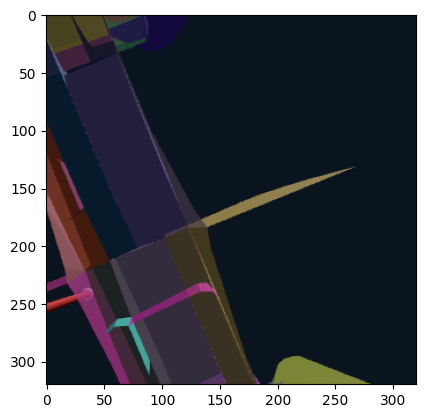

In [6]:
FINGERTIP_POS = -0.9
KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]
kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
scene.step()

def update_camera_position():
    wrist = kinova.get_link('end_effector_link')
    wrist_pos_offset = torch.Tensor([0.0, 0.0, 0.02]).to(device=wrist.get_pos().device)
    # Update the camera position based on the end effector position
    wrist_pos = wrist.get_pos()
    position = wrist.get_pos() + wrist_pos_offset
    rotation = wrist.get_ang()

    # get the mean position of the two fingertips
    left_fingertip = kinova.get_link('left_finger_dist_link')
    right_fingertip = kinova.get_link('right_finger_dist_link')
    middle = (left_fingertip.get_pos() + right_fingertip.get_pos()) / 2 + wrist_pos_offset

    # make a 4x4 transform out of the wrist position and rotation
    print(position.shape, rotation.shape)
    quat = gs.utils.geom.euler_to_quat(rotation)
    new_pos = gs.utils.geom.transform_by_quat(position, quat)


    cam_0.set_pose(pos=new_pos.cpu().numpy(), lookat=middle.cpu().numpy(), up=rotation.cpu().numpy())
    # cam_0.set_pose(pos=position.cpu().numpy(), lookat=middle.cpu().numpy(), up=(0, 0, 1))
update_camera_position()
img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
imgplot = plt.imshow(img)

In [7]:
# get the position of the left fingertip
links_pos = kinova.get_links_pos()
links_rot = kinova.get_links_ang()

wrist_idx = 6
wrist_pos = links_pos[wrist_idx]
wrist_rot = links_rot[wrist_idx]

wrist_rot, wrist_pos

(tensor([-0.0134,  0.0642,  0.0209], device='cuda:0'),
 tensor([ 0.2380, -0.0081,  0.1448], device='cuda:0'))

In [8]:
# Move the wrist to an arbitrary position
wrist_pos = np.array([0.5, 0.5, 0.5])
wrist_rot = np.array([0.5, 0.5, 0.5])

# get the joint positions that correspond to the new wrist position
ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=wrist_pos, quat=wrist_rot, rot_mask=[False, True, False])
ik_joints

[W 04/18/25 17:15:02.659 69085] [frontend_ir.cpp:begin_frontend_struct_for_on_external_tensor@1694] ti.loop_config(serialize=True) does not have effect on the struct for. The execution order is not guaranteed.


tensor([ 0.9370, -1.2310, -0.0349,  0.0610,  1.4153,  0.9374,  0.4478, -0.1336,
        -0.3602, -0.4273], device='cuda:0')

In [9]:
kinova.control_dofs_position(ik_joints[:-4], kdofs_idx[:-4])
scene.step()


In [10]:
import genesis_gym
demo_holder = genesis_gym.GenesisDemoHolder(use_eef=USE_EEF)


Loaded 96 demos from /home/j/workspace/genesis_sim2real/inthewild_trials
234 (900, 7) -- 246 (2623, 7) -- 331 (2868, 7) -- 236 (679, 7) -- 307 (1886, 7) -- 326 (966, 7) -- 263 (1051, 7) -- 278 (669, 7) -- 310 (1835, 7) -- 257 (1008, 7) -- 260 (1760, 7) -- 284 (1314, 7) -- 239 (2757, 7) -- 295 (6233, 7) -- 248 (3063, 7) -- 277 (854, 7) -- 261 (1412, 7) -- 305 (1262, 7) -- 297 (1138, 7) -- 322 (422, 7) -- 303 (2305, 7) -- 269 (4857, 7) -- 283 (1321, 7) -- 318 (1518, 7) -- 324 (649, 7) -- 321 (1715, 7) -- 333 (4070, 7) -- 243 (572, 7) -- 273 (1469, 7) -- 270 (3700, 7) -- 280 (725, 7) -- 237 (803, 7) -- 267 (1772, 7) -- 301 (1652, 7) -- 309 (1754, 7) -- 259 (1209, 7) -- 245 (3324, 7) -- 289 (603, 7) -- 253 (1195, 7) -- 244 (1048, 7) -- 300 (4771, 7) -- 252 (1543, 7) -- 247 (1737, 7) -- 268 (5077, 7) -- 265 (2928, 7) -- 328 (2767, 7) -- 279 (2000, 7) -- 302 (1164, 7) -- 285 (837, 7) -- 288 (3328, 7) -- 250 (3351, 7) -- 266 (1791, 7) -- 233 (926, 7) -- 314 (1301, 7) -- 315 (3891, 7) -- 296 (

In [11]:

if '_eef' not in str(demo_holder.dir):
    genesis_arm = kinova
    output_dir='./inthewild_trials_eef'
    output_dir = pl.Path(output_dir)
    new_demos = []
    for idx, (trial_id, d) in enumerate(demo_holder.demos):
        # if trial_id != 235: continue
        new_d = []
        for i in range(d.shape[0]): # for each joint position action [j0, j1, j2, j3, j4, j5, gripper]
            joint_pos_theta = d[i, :6]
            joint_pos, joint_quat = genesis_arm.forward_kinematics(torch.tensor(joint_pos_theta))
            eef_pos = joint_pos[6].cpu().numpy(); eef_quat = joint_quat[6].cpu().numpy()
            eef_euler = gs.utils.geom.quat_to_xyz(eef_quat)
            
            action = np.concatenate((eef_pos, eef_euler, d[i, 6:]), axis=-1)
            # print(', '.join([f'{x:+.1f}' for x in action]), '||', ', '.join([f'{x:+.1f}' for x in d[i, :]]))
            new_d.append(action)

        # save the demo out
        output_path = output_dir / f'{trial_id}_episodes.npy'
        # make the new directory if it doesn't exist
        output_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(output_path, new_d)

[W 04/18/25 17:15:13.238 69085] TaichiWarning
While compiling `_kernel_forward_kinematics_c102_0`, File "/home/j/workspace/genesis/Genesis/genesis/engine/entities/rigid_entity/rigid_entity.py", line 1400, in _kernel_forward_kinematics:
            self._solver.qpos[qs_idx[i_q_], envs_idx[i_b_]] = qpos[i_b_, i_q_]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Assign may lose precision: f32 <- f64


KeyboardInterrupt: 

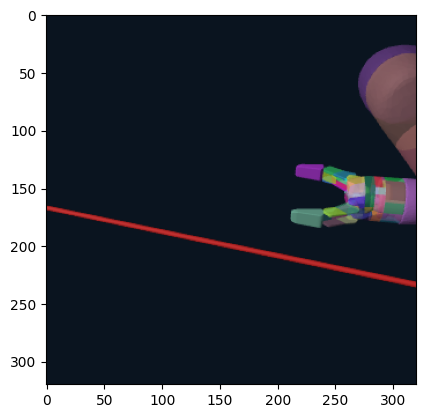

In [36]:
cam_0.set_pose(pos=(0.3, 0.6, 0.5), lookat=(0.5 ,0.0, 0.1), up=(0, 0, 1))
img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
imgplot = plt.imshow(img)

In [ ]:
# print out the link names
print([l.name for l in kinova._links])

In [ ]:

FINGERTIP_POS = -0.9
KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]
kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
scene.step()

# demo_holder.next_demo()
demo_holder.reset_current_demo()


In [ ]:
print(f'{USE_EEF=}')
from genesis.utils.geom import quat_to_xyz
next_joint_pos = demo_holder.next_action()['action']
# scene.clear_debug_objects()
# if next_joint_pos is not None:
while next_joint_pos is not None:
    # calculate the eef position given the eef joint position

    if USE_EEF:
        eef_pos, eef_euler, gripper_pos = next_joint_pos[:3], next_joint_pos[3:6], next_joint_pos[6:]

        eef_action = np.concatenate((eef_pos, eef_euler, gripper_pos), axis=-1)
        # convert euler to quat
        eef_quat = gs.utils.geom.xyz_to_quat(eef_euler)
        # get the joint positions that correspond to the new wrist position
        ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=eef_pos, quat=eef_quat, rot_mask=[True, True, True])
        
        print(', '.join(f'{x:+.1f}' for x in eef_action), '||', ', '.join(f'{x:+.1f}' for x in ik_joints))
        cmd = ik_joints[:-4]
    else:
        arm_pos, gripper_pos = next_joint_pos[:6], next_joint_pos[6:]
        # print(', '.join(f'{x:+.2f}' for x in arm_pos), ' gripper ', ', '.join(f'{x:.1f}' for x in gripper_pos))
        
        # get the current joint positions
        current_joint_pos = kinova.get_dofs_position(kdofs_idx)
        # print(', '.join(f'{x:+.2f}' for x in current_joint_pos))

        d = np.linalg.norm(np.array(arm_pos) - current_joint_pos[:-4].cpu().numpy())
        # print(f'---{d=:.2f}---')

        cmd = arm_pos # Use the arm position command directly
        if True: # from the arm position, calculate the eef_position, then convert that back to joint angles to test eef control
            joint_pos, joint_quat = kinova.forward_kinematics(torch.tensor(next_joint_pos))
            
            eef_pos, eef_quat = joint_pos[6], joint_quat[6]

            # convert quat to euler
            eef_xyz = quat_to_xyz(eef_quat.cpu().numpy())
            eef_quat = gs.utils.geom.xyz_to_quat(eef_xyz)

            tmp = np.concatenate((eef_pos.cpu().numpy(), eef_xyz, gripper_pos))
            # print(tmp[6:])
            
            # for pos in joint_pos:
            #     scene.draw_debug_sphere(pos, 0.01, color=(1, 0, 0))

            eef_action = np.concatenate((eef_pos.cpu().numpy(), eef_xyz, gripper_pos), axis=-1)

            ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=eef_pos, quat=eef_quat, rot_mask=[True, True, True])
            print(', '.join(f'{x:+.1f}' for x in eef_action), '||', ', '.join(f'{x:+.1f}' for x in ik_joints))
            
            cmd = ik_joints[:-4]

    # kinova.control_dofs_position(cmd, kdofs_idx[:-4])
    
    kinova.set_dofs_position(cmd, kdofs_idx[:-4])
    update_camera_position()
    scene.step()
    
    # display the image
    # img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
    # imgplot = plt.imshow(img)
    # plt.show(block=False)

    next_joint_pos = demo_holder.next_action()
    next_joint_pos = next_joint_pos['action'] if next_joint_pos is not None else None

else:
    print(f'No more actions')


